# Homework 2 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ and __twitter__ datasets as seen before in these two exercises. 

## Hand-in Instructions
- __Due: 13.04.2021 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due date
- Verify that `Dockerfile`, `environment.yml` and `requirements.txt` are properly written and notebook is functional
- Add necessary comments and discussion to make your queries readable

## Hive Documentation

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>

<div style="font-size: 150%" class="alert alert-block alert-warning">
    <b>Get yourself ready:</b> 
    <br>
    Before you jump into the questions, please first go through the notebook <a href='./prepare_env.ipynb'>prepare_env.ipynb</a> and make sure that your environment is properly set up.
    <br><br>
    <b>Cluster Usage:</b>
    <br>
    As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.
    <br><br>
    <b>Try to use as much HiveQL as possible and avoid using pandas operations.</b>
</div>

## Part I: SBB/CFF/FFS Data (40 Points)

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

__Initialization__

In [131]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

username = os.environ['JUPYTERHUB_USER']
hiveaddr = os.environ['HIVE_SERVER_2']
print("Operating as: {0}".format(username))

Operating as: xma


In [50]:
from pyhive import hive

# create connection
conn = hive.connect(host=hiveaddr, 
                    port=10000,
                    username=username) 
# create cursor
cur = conn.cursor()

### a) Type of transport - 10/40

In the exercise of week-3, you have already explored the stop distribution of different types of transport on 05.11.2018. Now, let's do the same for the whole dataset.

- Query `sbb_orc` to get the total number of stops for different types of transport in each month, and order it by time and type of transport.
|month_year|ttype|stops|
|---|---|---|
|...|...|...|
- Use `plotly` to create a facet bar chart partitioned by the type of transportation. 
- Document any patterns or abnormalities you can find.

__Note__: 
- In general, one entry in the `sbb_orc` table means one stop.
- You might need to filter out the rows where:
    - `BETRIEBSTAG` is not in the format of `__.__.____`
    - `PRODUKT_ID` is NULL or empty
- Facet plot with plotly: https://plotly.com/python/facet-plots/

In [106]:
query = """
    select * 
    from {0}.sbb_orc
    where HALTESTELLEN_NAME like 'Zürich%'
    
    limit 3
""".format(username)
pd.read_sql(query, conn)

sbb_orc.betriebstag sbb_orc.fahrt_bezeichner sbb_orc.betreiber_id  \
0          15.07.2020    85:773:687320-22759-1               85:773   
1          15.07.2020    85:773:687320-22759-1               85:773   
2          15.07.2020    85:773:687320-22759-1               85:773   

  sbb_orc.betreiber_abk    sbb_orc.betreiber_name sbb_orc.produkt_id  \
0                   VBG  Verkehrsbetriebe Glattal                Bus   
1                   VBG  Verkehrsbetriebe Glattal                Bus   
2                   VBG  Verkehrsbetriebe Glattal                Bus   

  sbb_orc.linien_id sbb_orc.linien_text sbb_orc.umlauf_id  \
0        85:773:781                 781            750119   
1        85:773:781                 781            750119   
2        85:773:781                 781            750119   

  sbb_orc.verkehrsmittel_text sbb_orc.zusatzfahrt_tf sbb_orc.faellt_aus_tf  \
0                           B                  false                 false   
1                           B                  false                 false   
2                           B                  false                 false   

  sbb_orc.bpuic sbb_orc.haltestellen_name sbb_orc.ankunftszeit  \
0       8591256     Zürich, Leutschenbach     15.07.2020 17:56   
1       8591172         Zürich, Hagenholz     15.07.2020 17:57   
2       8591318          Zürich, Riedbach     15.07.2020 17:58   

   sbb_orc.an_prognose sbb_orc.an_prognose_status sbb_orc.abfahrtszeit  \
0  15.07.2020 17:55:55                   PROGNOSE     15.07.2020 17:56   
1  15.07.2020 17:57:24                   PROGNOSE     15.07.2020 17:57   
2  15.07.2020 17:58:18                   PROGNOSE     15.07.2020 17:58   

   sbb_orc.ab_prognose sbb_orc.ab_prognose_status sbb_orc.durchfahrt_tf  
0  15.07.2020 17:56:30                   PROGNOSE                 false  
1  15.07.2020 17:57:42                   PROGNOSE                 false  
2  15.07.2020 17:58:36                   PROGNOSE                 false

In [52]:
query = """
    select date_format(to_date(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy'))), 'yyyy-MM') as month_year, 
        lower(PRODUKT_ID) as ttype,
        count(*) as stops
    from {0}.sbb_orc
    where BETRIEBSTAG != '__.__.____' and PRODUKT_ID is not null and length(PRODUKT_ID) > 0 and length(BETRIEBSTAG)>0 and date_format(to_date(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy'))), 'yyyy-MM') is not null
    group by lower(PRODUKT_ID), date_format(to_date(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy'))), 'yyyy-MM')
    order by month_year asc
""".format(username)
df_type = pd.read_sql(query, conn)

In [53]:
df_type

month_year        ttype     stops
0      2018-01          zug   4511653
1      2018-01       schiff      5163
2      2018-01         tram   5240546
3      2018-01          bus  15742859
4      2018-02          bus  14933670
..         ...          ...       ...
172    2020-12        metro    123047
173    2020-12       schiff      4653
174    2020-12         tram   7009027
175    2020-12  zahnradbahn     41785
176    2020-12          zug   4729340

[177 rows x 3 columns]

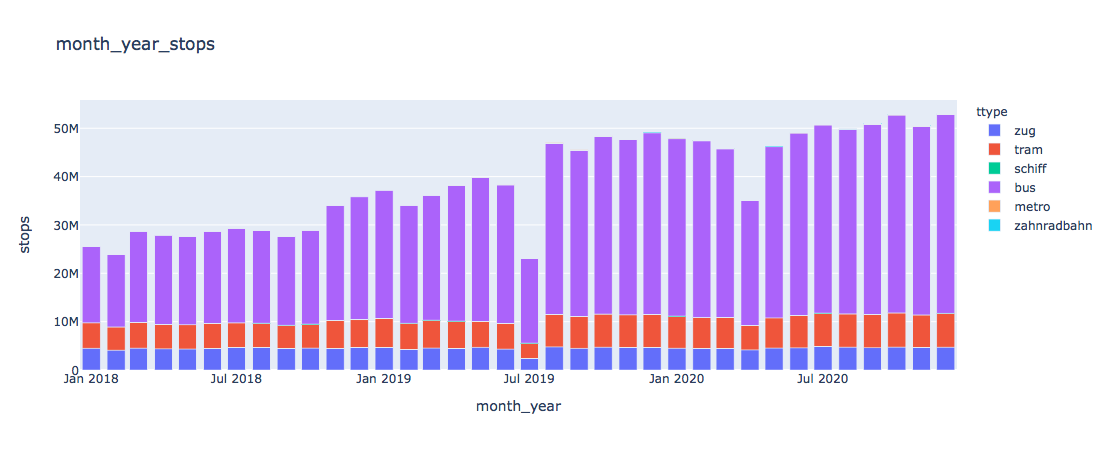

In [49]:
fig = px.bar(
    df_ttype,
    x="month_year",
    y="stops",
    color="ttype",
    title="month_year_stops"
    
    # TODO
)

# TODO: make your figure more readable

fig.show()

### b) Schedule - 10/40

- Select a typical week day (not Saturday, not Sunday, not a bank holiday) from `sbb_orc`. Query the one-day table and get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on that day. 
- Display the train number (`LINIEN_ID`) as well as the schedule (arrival and departure time) of the trains.

|train_number|departure|arrival|
|---|---|---|
|...|...|...|

__Note:__ 
- The schedule of IC from Genève to Lausanne has not changed for the past few years. You can use the advanced search of SBB's website to check your answer.
- Do not hesitate to create intermediary tables. 
- You might need to add filters on these flags: `ZUSATZFAHRT_TF`, `FAELLT_AUS_TF`, `DURCHFAHRT_TF` 
- Functions that could be useful: `unix_timestamp`, `to_utc_timestamp`, `date_format`.

In [69]:
# Drop table if exists
query = """
    drop table if exists {0}.geneve_station
""".format(username)
cur.execute(query)

# Create a table for IC trains in Geneva for a week day (e.g. 10/10/2019)
query = """
    create table {0}.geneve_station
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' 
        and HALTESTELLEN_NAME like 'Genève' 
        and BETRIEBSTAG like '10.10.2019'
        and FAELLT_AUS_TF like 'false'
        and DURCHFAHRT_TF like 'false'
""".format(username)
cur.execute(query)

# Drop table if exists
query = """
    drop table if exists {0}.lausanne_station
""".format(username)
cur.execute(query)

# Create a table for IC trains in Lausanne for a week day (e.g. 10/10/2019)
query = """
    create table {0}.lausanne_station
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' 
        and HALTESTELLEN_NAME like 'Lausanne' 
        and BETRIEBSTAG like '10.10.2019'
        and FAELLT_AUS_TF like 'false'
        and DURCHFAHRT_TF like 'false'
""".format(username)
cur.execute(query)

In [87]:
query = """
    select  
        geneve_station.LINIEN_ID as train_number, 
        to_utc_timestamp(1000*unix_timestamp(geneve_station.AB_PROGNOSE, 'dd.MM.yyy HH:mm'),"UTC") as departure,
        to_utc_timestamp(1000*unix_timestamp(lausanne_station.AN_PROGNOSE, 'dd.MM.yyy HH:mm'),"UTC") as arrival  
    from {0}.geneve_station FULL OUTER JOIN {0}.lausanne_station ON (geneve_station.LINIEN_ID = lausanne_station.LINIEN_ID)
    where 
        unix_timestamp(lausanne_station.AN_PROGNOSE, 'dd.MM.yyy HH:mm') > 0 and 
        unix_timestamp(geneve_station.AB_PROGNOSE, 'dd.MM.yyy HH:mm') > 0 and 
        unix_timestamp(lausanne_station.AN_PROGNOSE, 'dd.MM.yyy HH:mm') > unix_timestamp(geneve_station.AB_PROGNOSE, 'dd.MM.yyy HH:mm')
    order by geneve_station.LINIEN_ID
""".format(username)
df_geneve_lausanne = pd.read_sql(query, conn)

In [88]:
df_geneve_lausanne

train_number           departure             arrival
0           707 2019-10-10 05:42:00 2019-10-10 06:17:00
1           709 2019-10-10 06:43:00 2019-10-10 07:17:00
2           711 2019-10-10 07:43:00 2019-10-10 08:17:00
3           713 2019-10-10 08:44:00 2019-10-10 09:20:00
4           715 2019-10-10 09:43:00 2019-10-10 10:17:00
5           717 2019-10-10 10:44:00 2019-10-10 11:17:00
6           719 2019-10-10 11:43:00 2019-10-10 12:17:00
7           721 2019-10-10 12:42:00 2019-10-10 13:17:00
8           723 2019-10-10 13:43:00 2019-10-10 14:16:00
9           725 2019-10-10 14:45:00 2019-10-10 15:17:00
10          727 2019-10-10 15:44:00 2019-10-10 16:18:00
11          729 2019-10-10 16:43:00 2019-10-10 17:17:00
12          731 2019-10-10 17:44:00 2019-10-10 18:17:00
13          733 2019-10-10 18:43:00 2019-10-10 19:17:00
14          735 2019-10-10 19:43:00 2019-10-10 20:19:00
15          737 2019-10-10 20:50:00 2019-10-10 21:24:00

### c) Delay percentiles - 10/40

- Query `sbb_orc` to compute the 50th and 75th percentiles of __arrival__ delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. 
- Use `plotly` to plot your results in a proper way. 
- Which trains are the most disrupted? Can you find the tendency and interpret?

__Note:__
- Do not hesitate to create intermediary tables. 
- When the train is ahead of schedule, count this as a delay of 0.
- Use only stops with `AN_PROGNOSE_STATUS` equal to __REAL__ or __GESCHAETZT__.
- Functions that may be useful: `unix_timestamp`, `percentile_approx`, `if`

In [54]:
query = """
    drop table if exists {0}.geneva_main_station
""".format(username)
cur.execute(query)

query = """
    create table {0}.geneva_main_station
    stored as orc
    as 
        select LINIEN_ID as id,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where 
            VERKEHRSMITTEL_TEXT like 'IC' and 
            HALTESTELLEN_NAME like 'Genève' and 
            (AN_PROGNOSE_STATUS like 'REAL' or AN_PROGNOSE_STATUS like 'GESCHAETZT') and 
            cast(LINIEN_ID as int) >= 702 and 
            cast(LINIEN_ID as int) <= 730 and 
            (cast(LINIEN_ID as int)% 2) == 0
""".format(username)
cur.execute(query)

In [55]:
#give the delay of each entry
query = """
   select id, 
        case
            when actual_arrival > expected_arrival then actual_arrival - expected_arrival
            else 0
        end as delay
    from {0}.geneva_main_station
    order by delay asc
""".format(username)
df_delays_ic_gen=pd.read_sql(query, conn)

In [59]:
#compute the 50th and 75th percentiles of arrival delays for different IC trains
query="""
with delay_IC as(
    select id, 
        case
            when actual_arrival > expected_arrival then actual_arrival - expected_arrival
            else 0
        end as delay
    from {0}.geneva_main_station
    order by delay asc
)
select id,
       percentile_approx(delay,0.5) as 50th,
       percentile_approx(delay,0.75) as 75th
       from delay_IC
       group by id
       order by id

""".format(username)
pd.read_sql(query, conn)

id       50th        75th
0   702   0.000000   55.625000
1   704  15.000000   98.000000
2   706  14.642857  114.166667
3   708  19.000000  137.000000
4   710   7.000000   87.000000
5   712   0.000000   56.916667
6   714   0.000000   69.166667
7   716   0.000000   63.750000
8   718   0.000000   52.250000
9   720   0.000000   45.750000
10  722   0.000000   75.750000
11  724   6.000000   77.000000
12  726  24.000000  105.437500
13  728  12.000000  112.750000
14  730   0.000000  110.125000

In [64]:
#50th percentile of delays.
df_delays_ic_gen['delay'].quantile(0.5)

4.0

In [65]:
#75th percentile of delays.
df_delays_ic_gen['delay'].quantile(0.75)

82.0

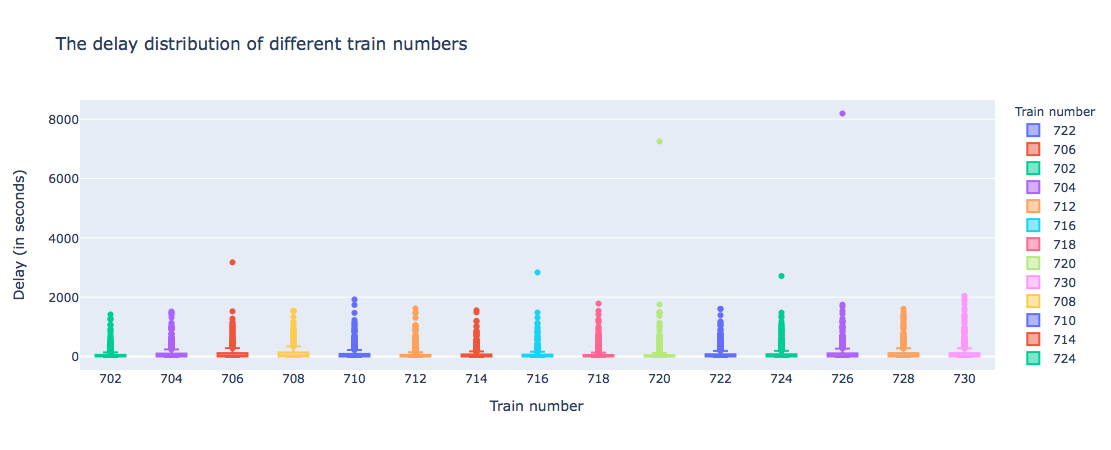

In [48]:
# we use tha delays(seconds) for all entrys
fig = px.box(
    df_delays_ic_gen,
    x="id",
    y="delay",
    color='id',
    labels={"id": "Train number",
            "delay": "Delay (in seconds)",
           },
    title="The delay distribution of different train numbers"
)

fig.update_xaxes(type='category', categoryorder='category ascending')
fig.show()

### d) Delay heatmap 10/40

- For each week (1 to 52) of each year (2018 to 2020), query `sbb_orc` to compute the median of delays of all trains __departing__ from any train stations in Zürich area during that week. 
- Use `plotly` to draw a heatmap (year x week) of the median delays. 
- In which weeks were the trains delayed the most/least? Can you explain the results?

__Note:__
- Do not hesitate to create intermediary tables. 
- When the train is ahead of schedule, count this as a delay of 0.
- Use only stops with `AB_PROGNOSE_STATUS` equal to __REAL__ or __GESCHAETZT__.
- For simplicty, a train station in Zürich area <=> it's a train station & its `HALTESTELLEN_NAME` starts with __Zürich__.
- Heatmap with `plotly`: https://plotly.com/python/heatmaps/
- Functions that may be useful: `unix_timestamp`, `from_unixtime`, `weekofyear`, `percentile_approx`, `if`

In [134]:
query = """
    drop table if exists {0}.zurich_station
""".format(username)
cur.execute(query)

query = """
    create table {0}.zurich_station
    stored as orc
    as 
        select LINIEN_ID as id,
               weekofyear(TO_DATE(FROM_UNIXTIME(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')))) as week,
               Year(TO_DATE(FROM_UNIXTIME(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy')))) as year,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual_departure
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Zürich%' 
        and PRODUKT_ID like 'Zug'
        and (AB_PROGNOSE_STATUS like 'REAL' or AB_PROGNOSE_STATUS like 'GESCHAETZT')
        
""".format(username)
cur.execute(query)

In [139]:
query = """
with delay_zurich as(
select id, week, year,
        case
            when actual_departure > expected_departure then actual_departure - expected_departure
            else 0
        end as delay
    from {0}.zurich_station
    order by delay asc
)
select week, year,percentile_approx(delay,0.5) as medians
from delay_zurich
group by week, year
order by year, week


""".format(username)
df_delays_zurich = pd.read_sql(query, conn)

In [140]:
df_delays_zurich

week  year    medians
0       1  2018  68.000000
1       2  2018  67.592593
2       3  2018  75.000000
3       4  2018  72.000000
4       5  2018  68.000000
..    ...   ...        ...
150    49  2020  78.000000
151    50  2020  78.000000
152    51  2020  75.000000
153    52  2020  69.000000
154    53  2020  65.000000

[155 rows x 3 columns]

In [144]:
# for the heatmap, you probably need to set the index first
df_delays_zurich.set_index(['year', 'week'])

medians
year week           
2018 1     68.000000
     2     67.592593
     3     75.000000
     4     72.000000
     5     68.000000
...              ...
2020 49    78.000000
     50    78.000000
     51    75.000000
     52    69.000000
     53    65.000000

[155 rows x 1 columns]

In [150]:
fig = px.imshow(
    df_delays_zurich,
    
    title='delays for week of year',
    
)

# TODO: make your figure more readable

fig.show()

ValueError: px.imshow only accepts 2D single-channel, RGB or RGBA images. An image of shape (155,) was provided.Alternatively, 3- or 4-D single or multichannel datasets can bevisualized using the `facet_col` or/and `animation_frame` arguments.

## Part II: Twitter Data (20 Points)

Data source: https://archive.org/details/twitterstream?sort=-publicdate 

In this part, you will leverage Hive to extract the hashtags from the source data, and then perform light exploration of the prepared data. 

### Dataset Description 

Format: the dataset is presented as a collection of textfiles containing one JSON document per line. The data is organized in a hierarchy of folders, with one file per minute. The textfiles have been compressed using bzip2. In this part, we will mainly focus on __2020 twitter data__.

Location: you can find the data on HDFS at the path `/data/twitter/json/2020/{month}/{day}/{hour}/{minute}.json.bz2`. 

Relevant fields: 
- `created_at`, `timestamp_ms`: The first is a human-readable string representation of when the tweet was posted. The latter represents the same instant as a timestamp in seconds since UNIX epoch. 
- `lang`: the language of the tweet content 
- `entities`: parsed entities from the tweet, e.g. hashtags, user mentions, URLs.
- In this repository, you can find [a tweet example](../data/tweet-example.json).

<div style="font-size: 100%" class="alert alert-block alert-danger">
    <b>Disclaimer</b>
    <br>
    This dataset contains unfiltered data from Twitter. As such, you may be exposed to tweets/hashtags containing vulgarities, references to sexual acts, drug usage, etc.
    </div>

### a) JsonSerDe - 4/20

In the exercise of week 4, you have already seen how to use the [SerDe framework](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+DDL#LanguageManualDDL-RowFormats&SerDe) to extract JSON fields from raw text format. 

In this question, please use SerDe to create an <font color="red" size="3px">EXTERNAL</font> table with __one day__ twitter data. You only need to extract three columns: `timestamp_ms`, `lang` and `entities`(with the field `hashtags` only) with following schema (you need to figure out what to fill in `...`):
```
timestamp_ms string,
lang         string,
entities     struct<hashtags:array<...<text:..., indices:...>>>
```

The table you create should be similar to:

| timestamp_ms | lang | entities |
|---|---|---|
| 1234567890001 | en | {"hashtags":[]} |
| 1234567890002 | fr | {"hashtags":[{"text":"hashtag1","indices":[10]}]} |
| 1234567890002 | jp | {"hashtags":[{"text":"hashtag1","indices":[14,23]}, {"text":"hashtag2","indices":[45]}]} |

__Note:__
   - JsonSerDe: https://cwiki.apache.org/confluence/display/Hive/LanguageManual+DDL#LanguageManualDDL-RowFormats&SerDe
   - Hive data types: https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Types#LanguageManualTypes

In [ ]:
query="""
    drop table if exists {0}.hashtags_one_day_intermediary
""".format(username)
cur.execute(query)

query="""
    create external table {0}.hashtags_one_day_intermediary(
        
        /* TODO */
    
    )
    
    /* TODO */
    
""".format(username)
cur.execute(query)

query="""
    select * from {0}.hashtags_one_day_intermediary limit 10
""".format(username)
pd.read_sql(query, conn)

### b) Explosion - 4/20

In a), you create a table where each row could contain a list of multiple hashtags. Create another table by normalizing the table obtained from the previous step. This means that each row should contain exactly one hashtag. Include `timestamp_ms` and `lang` in the resulting table, as shown below.

| timestamp_ms | lang | hashtag |
|---|---|---|
| 1234567890001 | es | hashtag1 |
| 1234567890001 | es | hashtag2 |
| 1234567890002 | en | hashtag2 |
| 1234567890003 | zh | hashtag3 |

__Note:__
   - `LateralView`: https://cwiki.apache.org/confluence/display/Hive/LanguageManual+LateralView
   - `explode` function: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF#LanguageManualUDF-explode>

In [ ]:
query="""
    drop table if exists {0}.hashtags_one_day
""".format(username)
cur.execute(query)

query="""
    create table if not exists {0}.hashtags_one_day
    stored as orc
    as
        
        /* TODO */
        
""".format(username)
cur.execute(query)

query="""
    select * from {0}.hashtags_one_day limit 10
""".format(username)
pd.read_sql(query, conn)

### c) Hashtags - 8/20

Query the normailized table you obtained in b). Create a table of the top 20 most mentioned hashtags with the contribution of each language. And, for each hashtag, order languages by their contributions. You should have a table similar to:

|hashtag|lang|lang_count|total_count|
|---|---|---|---|
|hashtag_1|en|2000|3500|
|hashtag_1|fr|1000|3500|
|hashtag_1|jp|500|3500|
|hashtag_2|te|500|500|

Use `plotly` to create a stacked bar chart to show the results.

__Note:__ to properly order the bars, you may need:
```python
fig.update_layout(xaxis_categoryorder = 'total descending')
```

In [ ]:
# You may need more than one query, do not hesitate to create more
# query = """
#
#     /* TODO */
#
# """
# cur.execute(query, conn)

query="""
    
    /* TODO */
    
""".format(username)
df_hashtag = pd.read_sql(query, conn)

In [ ]:
fig = px.bar(
    df_hashtag,
    
    # TODO

)

# TODO: make your figure more readable

fig.show()

### d) HBase - 4/20

In the lecture and exercise of week-4, you have learnt what's HBase, how to create an Hbase table and how to create an external Hive table on top of the HBase table. Now, let's try to save the results of question c) into HBase, such that each entry looks like:
```
(b'PIE', {b'cf1:total_count': b'31415926', b'cf2:langs': b'ja,en,ko,fr'})
``` 
where the key is the hashtag, `total_count` is the total count of the hashtag, and `langs` is a string of language abbreviations concatenated with commas. 

__Note:__
- To accomplish the task, you need to follow these steps:
    - Create an Hbase table called `twitter_hbase`, in **your hbase namespace**, with two column families and fields (cf1, cf2)
    - Create an external Hive table called `twitter_hive_on_hbase` on top of the Hbase table. 
    - Populate the HBase table with the results of question c).
- You may find function `concat_ws` and `collect_list` useful.

In [ ]:
import happybase
hbaseaddr = os.environ['HBASE_SERVER']
hbase_connection = happybase.Connection(hbaseaddr, transport='framed',protocol='compact')

In [ ]:
# TODO

# That's all, folks!